In [1]:
#import the libraries 

import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import fftpack,signal
import matplotlib
from matplotlib.ticker import ScalarFormatter
from astropy.visualization import (MinMaxInterval, SqrtStretch, ImageNormalize, ZScaleInterval)
import scipy
import json
import subprocess
import os
import tqdm

from exocrires import spectra_2d
from exocrires import info
from exocrires import analysis

#path='/Volumes/Macintosh HD/Users/richard/project_EXOCRIRES/thesis_ms'
path='/Users/richard/Library/CloudStorage/OneDrive-AlmaMaterStudiorumUniversitàdiBologna/project_EXOCRIRES/AB_Aur'

In [2]:
#with the new version of ETC, it is possible to input the magnitude and generate outputs in a different band
#input wavelength setting
lambda_range=info.lambda_range
'''
lambda_range={'key':['Y1029', 'J1226', 'H1559', 'K2166', 'L3377'], 'order':[range(59,50,-1), range(50,41,-1), range(39,30,-1), range(29,22,-1), range(20,13,-1)],\
              'wave':[[[949.898, 968.753],[965.933,985.463],[982.886,1002.754], [1000.440,1020.655], [1018.747,1039.200], [1037.493,1058.426], [1057.032,1078.362], [1077.326,1099.053], [1098.400,1120.709]],\
                      [[1116.376,1139.333], [1139.175,1162.592], [1162.922,1186.818], [1187.838,1212.372], [1213.484,1238.399], [1240.439,1265.748], [1268.607,1294.634], [1298.215,1324.672], [1328.947,1356.153]],\
                      [[1423.591,1453.833], [1461.242,1492.000], [1500.747,1532.329], [1542.754,1574.887], [1586.512,1619.860], [1632.892,1667.558], [1682.578,1717.947], [1735.084,1771.517], [1790.793,1828.480]],\
                      [[1921.468,1961.242], [1990.149,2031.185], [2063.682,2106.368], [2143.293,2187.413], [2228.779,2274.862], [2321.520,2369.682], [2422.230,2472.411]],\
                     [[2842.489,2896.056], [2992.166,3048.532], [3158.458,3217.933], [3344.291,3407.238], [3553.320,3620.163], [3790.165,3861.417], [4060.763,4137.040]]]}
'''
#input steallr magnitude: y-j-h-k


#---use black body of T=7200K, R=1.6R_sun for Y band magnitude---#
'''
data_star=np.loadtxt(path+'/black_body_7200.dat', skiprows=1)

band_y = np.loadtxt(path+'/SPHERE_IRDIS_B_Y.dat', skiprows=1)
band_y=np.array((band_y[:,0]*10, band_y[:,1]))
b_y=[band_y[0].min(),band_y[0].max()]
zero_flux_y=5.5671e-10


r_sun = 6.957e10
r_star=1.6*r_sun

pc = 3.086e18
dis = 114.8*pc

mask=np.array((data_star[:,0]>=b_y[0])&(data_star[:,0]<=b_y[1]))
data_star_cut=data_star[mask]
spec_star=np.interp(band_y[0], data_star_cut[:,0], data_star_cut[:,1])

int_star=np.trapz(spec_star*band_y[1], band_y[0])/np.trapz(band_y[1], band_y[0])

rec_star= 0.5*np.square(r_star/dis)*int_star

m_s_y= -2.5*np.log10(rec_star*(1/zero_flux_y)) # Y band magnitude
'''
#---use black body of T=9800K, R=1.6R_sun for Y band magnitude---#


#stellar_mag=[['Y', np.round(m_s_y,2)],['J',7.31],['H', 6.91],['K', 6.41], ['L', 999]]
stellar_mag=[['Y', 999], ['J',5.936],['H',5.062],['K', 4.230], ['L', 999]]


# Run  the Color Analysis first to retrieve the Apparent Magnitude for Planets

In [ ]:
#see eg_analysis.ipynb
mag_estimate=pd.read_csv('/Volumes/JCP_work/thesis_ms/mag_estimate.csv')

In [ ]:
r_j = 6.9950e9
pc = 3.086e18
nu=1

radi =  nu*r_j

band_l = np.loadtxt('/Volumes/JCP_work/thesis_ms/Paranal_ERIS.Lp_short.dat',skiprows=1)
#band_j=np.sort(band_j, axis=0)
band_l=np.array((band_l[:,0], band_l[:,1]))
b_l=[band_l[0].min(),band_l[0].max()]
zero_flux=8.35139e-12

dat_pl=np.loadtxt('/Volumes/JCP_work/thesis_ms/models_1683734698/bt-settl/lte011-3.5-0.0.BT-Settl.7.dat.txt')
dat_pl=np.array([dat_pl[:,0], dat_pl[:,1]])

ana=analysis.planet_para(data_planet=dat_pl)
mag_p=ana.mag_direct(radi, dis, solid_angle=2*np.pi, transmission=band_l, zero=zero_flux, band=b_l)

# 1. Process the Spectrum of the Host Star

In [27]:
data=spectra_2d.load_json(path+'/input_0611_ab_aur.json','r')
data

{'target': {'morphology': {'morphologytype': 'point'},
  'sed': {'sedtype': 'spectrum',
   'spectrum': {'spectrumtype': 'upload'},
   'extinctionav': 0.55},
  'brightness': {'brightnesstype': 'mag',
   'magband': 'K',
   'mag': 4.23,
   'magsys': 'vega'}},
 'sky': {'airmass': 1.9, 'moon_fli': 0.5, 'pwv': 1.5},
 'seeingiqao': {'params': {'gsmag': 9, 'turbulence_category': 70},
  'mode': 'aongs',
  'aperturepix': 35},
 'instrument': {'slit': 0.2,
  'settingkey': 'K2166',
  'polarimetry': 'free',
  'order': [29, 28, 27, 26, 25, 24, 23]},
 'timesnr': {'DET1.NDIT': 70, 'DET1.DIT': 50},
 'output': {'throughput': {'atmosphere': True,
   'telescope': True,
   'instrument': True,
   'blaze': True,
   'enslittedenergy': True,
   'detector': True,
   'totalinclsky': True},
  'snr': {'snr': True, 'noise_components': True},
  'sed': {'target': True, 'sky': True},
  'signals': {'obstarget': True, 'obssky': True, 'obstotal': True},
  'maxsignals': {'maxpixeltarget': True,
   'maxpixelsky': True,
   '

In [28]:
out_put=[]
for i in data['output']:
    if i == 'psf':
        out_put.append('%s'%i)
    else:   
        for j in data['output'][i]:
            out_put.append('%s_%s'%(i,j))
out_put=[string.lower() for string in out_put] 

In [29]:
out_put

['throughput_atmosphere',
 'throughput_telescope',
 'throughput_instrument',
 'throughput_blaze',
 'throughput_enslittedenergy',
 'throughput_detector',
 'throughput_totalinclsky',
 'snr_snr',
 'snr_noise_components',
 'sed_target',
 'sed_sky',
 'signals_obstarget',
 'signals_obssky',
 'signals_obstotal',
 'maxsignals_maxpixeltarget',
 'maxsignals_maxpixelsky',
 'maxsignals_maxpixeltotal',
 'dispersion_dispersion',
 'psf']

In [13]:
day='0611'
input_json_name='input_0611_ab_aur.json'
filename=path+'/upload_phoenix_K2166_10km.dat'

for x in range(3,4):
    
    #modify the parameters
    '''
    if x!=4:
        continue
    '''
    
    if stellar_mag[x][1] != 999:
    
        data['target']['brightness']['magband']=stellar_mag[x][0]
        data['target']['brightness']['mag']= stellar_mag[x][1]
    else:
        data['target']['brightness']['magband']=stellar_mag[1][0]
        data['target']['brightness']['mag']= stellar_mag[1][1]
        
    
    #data['target']['sed']['spectrum']['spectrumtype']='template'
    #data['target']['sed']['spectrum']['params']={"catalog":"PHOENIX","id":"9800:4.5"}
    #data['target']['sed']['extinctionav']=0.55
    
    data['instrument']['settingkey']=lambda_range['key'][x]
    data['instrument']['order']= [m for m in lambda_range['order'][x]]
    '''
    data['timesnr']['DET1.DIT']=120
    data['timesnr']['DET1.NDIT']=30
    '''
    
    data['sky']['airmass']=1.9
    
    with open(path+input_json_name, 'w') as file:
        json.dump(data, file)
        
    key=lambda_range['key'][x]
    folder_band =path+'/%s/star/%s/'%(day,key)

    if os.path.exists(folder_band) != True:

        print('create folder:', folder_band)

        subprocess.call(['mkdir', folder_band])
        
    #===start the generation===    
        
    data=spectra_2d.load_json(path+input_json_name,'r')
    
    print('The ETC is running in', data['instrument']['settingkey'], ' with the maximum order is', data['instrument']['order'][0])
    print('With magnitude in', data['target']['brightness']['mag'])
    
    print('---Start UP---')

    simu_star=spectra_2d.spectra_2d(path_etc_local=path+'/etc_cli.py', path_etc_input=path+input_json_name, path_input_modi=path+'/modi_input_%s_AO.json'%day,\
             path_etc_output=path+'/%s/star/%s/'%(day,lambda_range['key'][x]), target='star',\
        aperture_size=35, date='%s'%day,\
        order_window=lambda_range['wave'][x],\
        order_number=[m for m in lambda_range['order'][x]])

    simu_star.output_json(star_template=filename)

    simu_star.json2ascii(path_json2ascii=path+'/etc_json2ascii.py')

    simu_star.ascii2txt(output=out_put)
    #simu_star.ascii2txt()

    data_log_sig, data_log_sed=simu_star.signal(detectors=3, contribution='target', focal_plane=(2048, 2048*3), SED=True)
    #data_log_sig=simu_star.signal(detectors=3, contribution='target', focal_plane=(2048, 2048*3))

    data_log_sig.to_csv(simu_star.path_output+'stellar_simu_%s.csv'%lambda_range['key'][x])
    data_log_sed.to_csv(simu_star.path_output+'stellar_simu_sed_%s.csv'%lambda_range['key'][x])
    

The ETC is running in K2166  with the maximum order is 29
With magnitude in 4.23
---Start UP---


mkdir: /Users/richard/Library/CloudStorage/OneDrive-AlmaMaterStudiorumUniversitàdiBologna/project_EXOCRIRES/AB_Aur/0611/star/K2166/ascii_1/: File exists
mkdir: /Users/richard/Library/CloudStorage/OneDrive-AlmaMaterStudiorumUniversitàdiBologna/project_EXOCRIRES/AB_Aur/0611/star/K2166/ascii_3/: File exists
mkdir: /Users/richard/Library/CloudStorage/OneDrive-AlmaMaterStudiorumUniversitàdiBologna/project_EXOCRIRES/AB_Aur/0611/star/K2166/ascii_5/: File exists
mkdir: /Users/richard/Library/CloudStorage/OneDrive-AlmaMaterStudiorumUniversitàdiBologna/project_EXOCRIRES/AB_Aur/0611/star/K2166/ascii_7/: File exists
mkdir: /Users/richard/Library/CloudStorage/OneDrive-AlmaMaterStudiorumUniversitàdiBologna/project_EXOCRIRES/AB_Aur/0611/star/K2166/ascii_9/: File exists
mkdir: /Users/richard/Library/CloudStorage/OneDrive-AlmaMaterStudiorumUniversitàdiBologna/project_EXOCRIRES/AB_Aur/0611/star/K2166/ascii_11/: File exists
mkdir: /Users/richard/Library/CloudStorage/OneDrive-AlmaMaterStudiorumUniversitàd

the ETC calculation is done, the output file is saved at /Users/richard/Library/CloudStorage/OneDrive-AlmaMaterStudiorumUniversitàdiBologna/project_EXOCRIRES/AB_Aur/0611/star/K2166/
Conversion from json to ascii starts
File Not Found: 1-29-1-snr_noise_components
File Not Found: 1-29-1-psf
txt_done_1_29_1
File Not Found: 1-28-1-snr_noise_components
File Not Found: 1-28-1-psf
txt_done_1_28_1
File Not Found: 1-27-1-snr_noise_components
File Not Found: 1-27-1-psf
txt_done_1_27_1
File Not Found: 1-26-1-snr_noise_components
File Not Found: 1-26-1-psf
txt_done_1_26_1
File Not Found: 1-25-1-snr_noise_components
File Not Found: 1-25-1-psf
txt_done_1_25_1
File Not Found: 1-24-1-snr_noise_components
File Not Found: 1-24-1-psf
txt_done_1_24_1
File Not Found: 1-23-1-snr_noise_components
File Not Found: 1-23-1-psf
txt_done_1_23_1
File Not Found: 1-29-2-snr_noise_components
File Not Found: 1-29-2-psf
txt_done_1_29_2
File Not Found: 1-28-2-snr_noise_components
File Not Found: 1-28-2-psf
txt_done_1_28_

In [14]:
for j in range(3,4):
    key=lambda_range['key'][j]
    save_p=path+'/%s/star/%s/'%(day,key)
    data_log=pd.read_csv(save_p+'stellar_simu_%s.csv'%key)
    simu_star.plot_signal(wave_count_sort=data_log, max_percentile=99,\
                      save_path=save_p+'star_simu_%s.png'%key, interv=ZScaleInterval())

# 2. Process the Sky Background

In [15]:
# The sky background distribution should be the same for each run of output data. Therefore we only need to run it once with any input specgtrum of the planet
day='0611'

for j in range(3,4):
    
    key=lambda_range['key'][j]
    save_p=path+'/%s/sky_noi/%s/'%(day,key)
    
    if os.path.exists(save_p) != True:

        subprocess.call(['mkdir', save_p])
        
    simu_star=spectra_2d.spectra_2d(path_etc_local=path+'/etc_cli.py', path_etc_input=path+input_json_name, path_input_modi=path+'/modi_input_%s_AO.json'%day,\
             path_etc_output=path+'/%s/star/%s/'%(day,lambda_range['key'][j]), target='star',\
        aperture_size=35, date='%s'%day,\
        order_window=lambda_range['wave'][j],\
        order_number=[m for m in lambda_range['order'][j]])

    data_log_k=simu_star.signal(detectors=3, focal_plane=(2048, 2048*3), contribution='sky')
    data_log_k.to_csv(save_p+'sky_simu.csv')
    simu_star.plot_signal(wave_count_sort=data_log_k, max_percentile=99.99, save_path=save_p+'sky_simu.png', interv=ZScaleInterval(), Nor=None)

# 3. Process the Spectrum of the Planet and Generate the combination cube

In [7]:
day='0611'

#set up the array for contrast data
cont=np.zeros((55, 2, 2048*3))

#set up noise parameters 
read=6 #e-/pix, width of the distribution
dark=0.003 #e-/pix/s, width of the distribution
dit=50
ndit=70
nspec=1
nspat=119 #nspat for aperture 119

npix=nspec*nspat
ndark=dit*dark*nspec*nspat #e-/pix/exposure

#set up the angular separation (pix)
po=int(np.ceil(0.592/0.059))

if os.path.exists(path+'/%s/planet'%day) != True:
    
    subprocess.call(['mkdir', path+'/%s/planet'%day])

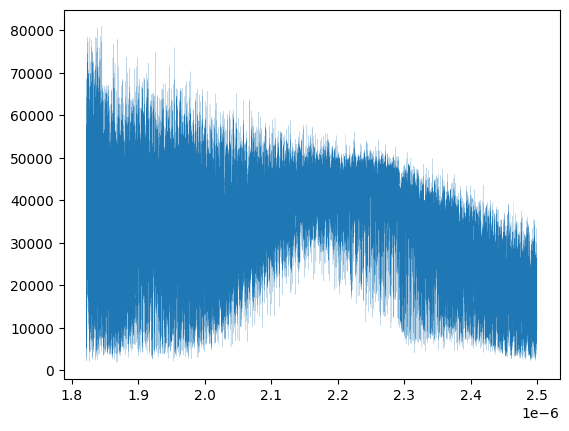

In [8]:
#prepare the input High-res SED from Lorenzo's library if we want to use high-res spectra

data=np.loadtxt(path+'/upload_lowres_K2166_10km.dat')
spec=data[:,1]
wave=data[:,0]

#For AB Aur b we still use BT-Settl cuz it's published, remember to check the units, ETC supports only m for wavelength, [W.m-1] or [erg/s/cm2/A] for energy density
#data=np.loadtxt(path+'/bt-Settl/lte020-3.5-0.0.BT-Settl.7.dat.txt.dat')
#spec=data[:,1]
#wave=data[:,0]#*1e-10

mask=np.where((wave>1.9e-6)&(wave<2.5e-6))

plt.plot(wave, spec, linewidth=0.1)
#plt.xlim(0.5e-6, 2.5e-6)
plt.show()

#data_convert=np.array([wave[mask], spec[mask]]).T
#np.savetxt(path+'/bt-settl/AB_aur_b_sed_20.dat', data_convert)

In [3]:
r_j = 6.9950e9
r_sun = 6.957e10
pc = 3.086e18
AU=1.496e13
nu=1

#Load the planet magnitude if known (e.g. AB Aur b)
m_obs=[['Y', 999], ['J', 15.15], ['H', 14.56], ['K', 14.01], ['L', 13.34]] #YJHKL mags, L mag as a 5sigma threshold


#Calculate the planet magnitude from observation if not known (e.g. HD 169142b)

'''
radi =  nu*r_j
dis = 114.8*pc
r_star = 1.6*r_sun

mag_es_convert=pd.read_csv(path+'/mag_estimate.csv')

#zero-point
c=scipy.constants.speed_of_light

zero_flux_j=3.06e-10 #(erg/cm2/s/A)
zero_flux_k=4.08e-11 #(erg/cm2/s/A), Ks
zero_flux_h=1.188e-10 #(erg/cm2/s/A), B_H
zero_flux_y=5.5671e-10

#--flux contrast at different bands--#
p_s_j = 1.72e-5 #J band
p_s_j_err = 6.16e-6

p_s_h2 = 1.93e-5
p_s_h2_err = 1.17e-5
#p_s_h2_err= 6.16e-6

p_s_k12 = 5.1e-5  # K band not detectable with SPHERE in 3 sigma

p_s_y = 1.49e-5
p_s_y_err = 5.95e-6

#--apparent magnitude of the host star--#
m_s_j = 7.31 #J band
m_s_k = 6.41 #K band
m_s_h = 6.91 #H band 

#---use black body of T=7200K, R=1.6R_sun for Y band magnitude---#
data_star=np.loadtxt(path+'/black_body_7200.dat', skiprows=1)

mask=np.array((data_star[:,0]>=b_y[0])&(data_star[:,0]<=b_y[1]))
data_star_cut=data_star[mask]
spec_star=np.interp(band_y[0], data_star_cut[:,0], data_star_cut[:,1])

int_star=np.trapz(spec_star*band_y[1], band_y[0])/np.trapz(band_y[1], band_y[0])

rec_star= 0.5*np.square(r_star/dis)*int_star

m_s_y= -2.5*np.log10(rec_star*(1/zero_flux_y)) # Y band magnitude

retrieve=analysis.planet_para()

#observed_flux with zero-point included
m_p_j=retrieve.mag_convert(flux_ratio=p_s_j, stellar_mag=m_s_j, error_b=p_s_j_err, error_p=p_s_j_err, \
                          flux=True, zero=None)

m_p_h=retrieve.mag_convert(flux_ratio=p_s_h2, stellar_mag=m_s_h, error_b=p_s_h2_err, error_p=p_s_h2_err, \
                          flux=True, zero=None) #!!!could be wrong!!!

m_p_y=retrieve.mag_convert(flux_ratio=p_s_y, stellar_mag=m_s_y, error_b=p_s_y_err, error_p=p_s_y_err, \
                          flux=True, zero=None)

m_p_k_non=retrieve.mag_convert(flux_ratio=p_s_k12, stellar_mag=m_s_k,\
                              flux=True, zero=None)

#convert the error of flux measurement from the flux contrast measurement 
m_obs=[['Y', m_p_y[0][1]], ['J',m_p_j[0][1]], ['H',m_p_h[0][1]], ['K',m_p_k_non[0][1]], ['L',999.0]] #YJHKL mags
f_obs=np.array([m_p_y[1][1], m_p_j[1][1], m_p_h[1][1], m_p_k_non[1][1]])
f_obs_err=np.array([m_p_y[1][1]-m_p_y[1][0], m_p_j[1][1]-m_p_j[1][0], m_p_h[1][1]-m_p_h[1][0], 1]) #no error measurement in k band
'''

"\nradi =  nu*r_j\ndis = 114.8*pc\nr_star = 1.6*r_sun\n\nmag_es_convert=pd.read_csv(path+'/mag_estimate.csv')\n\n#zero-point\nc=scipy.constants.speed_of_light\n\nzero_flux_j=3.06e-10 #(erg/cm2/s/A)\nzero_flux_k=4.08e-11 #(erg/cm2/s/A), Ks\nzero_flux_h=1.188e-10 #(erg/cm2/s/A), B_H\nzero_flux_y=5.5671e-10\n\n#--flux contrast at different bands--#\np_s_j = 1.72e-5 #J band\np_s_j_err = 6.16e-6\n\np_s_h2 = 1.93e-5\np_s_h2_err = 1.17e-5\n#p_s_h2_err= 6.16e-6\n\np_s_k12 = 5.1e-5  # K band not detectable with SPHERE in 3 sigma\n\np_s_y = 1.49e-5\np_s_y_err = 5.95e-6\n\n#--apparent magnitude of the host star--#\nm_s_j = 7.31 #J band\nm_s_k = 6.41 #K band\nm_s_h = 6.91 #H band \n\n#---use black body of T=7200K, R=1.6R_sun for Y band magnitude---#\ndata_star=np.loadtxt(path+'/black_body_7200.dat', skiprows=1)\n\nmask=np.array((data_star[:,0]>=b_y[0])&(data_star[:,0]<=b_y[1]))\ndata_star_cut=data_star[mask]\nspec_star=np.interp(band_y[0], data_star_cut[:,0], data_star_cut[:,1])\n\nint_star=np.tra

In [4]:
input_json_name='/input_0609_ab_aur_b.json'
data_pp=spectra_2d.load_json(path+input_json_name,'r')
'''
data_pp['target']['brightness']['params']['mag']=mag_p[0]
data_pp['timesnr']['DET1.DIT']=120
'''
data_pp

{'target': {'morphology': {'morphologytype': 'point'},
  'sed': {'sedtype': 'spectrum',
   'spectrum': {'spectrumtype': 'upload'},
   'extinctionav': 15.0},
  'brightness': {'brightnesstype': 'mag',
   'magband': 'K',
   'mag': 9.01,
   'magsys': 'vega'}},
 'sky': {'airmass': 1.9, 'moon_fli': 0.5, 'pwv': 1.5},
 'seeingiqao': {'params': {'gsmag': 9, 'turbulence_category': 70},
  'mode': 'aongs',
  'aperturepix': 35},
 'instrument': {'slit': 0.2,
  'settingkey': 'K2166',
  'polarimetry': 'free',
  'order': [29, 28, 27, 26, 25, 24, 23]},
 'timesnr': {'DET1.NDIT': 70, 'DET1.DIT': 50},
 'output': {'throughput': {'atmosphere': False,
   'telescope': False,
   'instrument': False,
   'blaze': False,
   'enslittedenergy': False,
   'detector': False,
   'totalinclsky': False},
  'snr': {'snr': True, 'noise_components': True},
  'sed': {'target': True, 'sky': True},
  'signals': {'obstarget': True, 'obssky': True, 'obstotal': True},
  'maxsignals': {'maxpixeltarget': True,
   'maxpixelsky': Tru

In [5]:
out_put=[]
for i in data_pp['output']:
    if i == 'psf':
        out_put.append('%s'%i)
    else:   
        for j in data_pp['output'][i]:
            out_put.append('%s_%s'%(i,j))
out_put=[string.lower() for string in out_put] 

## 3.1-1 Branch_1: Input a Certain SED
If the temperature and gravity are already known. We could select a certain theoretical spectrum and input it as SED. Please use the codes below.

In [39]:
day='0611'
filename=path+'/upload_lowres_K2166_10km.dat'
name_model='22-3.5-0.0'


sed=np.loadtxt(filename)


for x in range(3,4):
    
    key=lambda_range['key'][x]
    
    print ('The simulation is running on %s'%key)
    
    data_log=pd.read_csv(path+'/%s/star/%s/stellar_simu_%s.csv'%(day,key,key))
    #data_log=np.zeros(shape=(35,6144))
    data_log_k=pd.read_csv(path+'/%s/sky_noi/%s/sky_simu.csv'%(day,key))
    #data_log_k=np.zeros(shape=(35,6144))

    '''
    if os.path.exists(path+'/%s/planet/%s/%s'%(day, filename[-33:-23],  key)) == True:
        continue
    '''

    print ('now we start to process the model: %s'%filename)

    folder_model=path+'/%s/planet/%s/'%(day, name_model)
    folder_band =path+'/%s/planet/%s/%s/'%(day,name_model,key)

    if os.path.exists(folder_model) != True:

        print('create folder:', folder_model)

        subprocess.call(['mkdir', folder_model])

    elif os.path.exists(folder_band) != True:

        print('create folder:', folder_band)

        subprocess.call(['mkdir', folder_band])


    if int(m_obs[x][1])!=999:
        data_pp['target']['brightness']['magband']=m_obs[x][0]
        data_pp['target']['brightness']['mag']=np.round(float(m_obs[x][1]),2)-5 # we increase the magnitude for 5 to make the planet signal 100x larger 


    else:
        data_pp['target']['brightness']['magband']=m_obs[1][0]
        data_pp['target']['brightness']['mag']=np.round(float(m_obs[1][1]),2)

    data_pp['instrument']['settingkey']=lambda_range['key'][x]
    data_pp['instrument']['order']= [n for n in lambda_range['order'][x]]    

    #data_pp['timesnr']['DET1.DIT']=50
    #data_pp['timesnr']['DET1.NDIT']=70
    
    data_pp['target']['sed']['extinctionav']=15.0
    data_pp['sky']['airmass']=1.9
    data_pp['sky']['pwv']=1.5

    with open(path+input_json_name, 'w') as file:
        json.dump(data_pp, file)

    print ('apparent magnitude for the planet is taken as %s'%data_pp['target']['brightness']['mag'])

    #===start processing the planet emission===

    simu_planet=spectra_2d.spectra_2d (path_etc_local=path+'/etc_cli.py', path_etc_input=path+input_json_name, path_input_modi=path+'/modi_input_%s_p_AO.json'%day,\
                 path_etc_output=path+'/%s/planet/%s/%s/'%(day, name_model, key), target='planet', aperture_size=35, date='%s'%day,\
            order_window=lambda_range['wave'][x],\
            order_number=[m for m in lambda_range['order'][x]],\
            model_name=filename)

    simu_planet.output_json()

    simu_planet.json2ascii(path_json2ascii=path+'/etc_json2ascii.py')

    simu_planet.ascii2txt(output=out_put)

    data_log_p=simu_planet.signal(detectors=3, focal_plane=(2048, 2048*3), contribution='target')

    data_log_p.to_csv(simu_planet.path_output+'planet_simu.csv')

    print ('Planet-only 2d spectrum done:%s'%simu_planet.path_output)

    simu_planet.plot_signal(data_log_p, max_percentile=99,\
                            save_path=simu_planet.path_output+'planet_simu.png', interv=ZScaleInterval())

The simulation is running on K2166
now we start to process the model: /Users/richard/Library/CloudStorage/OneDrive-AlmaMaterStudiorumUniversitàdiBologna/project_EXOCRIRES/AB_Aur/upload_lowres_K2166_10km.dat
apparent magnitude for the planet is taken as 9.01


mkdir: /Users/richard/Library/CloudStorage/OneDrive-AlmaMaterStudiorumUniversitàdiBologna/project_EXOCRIRES/AB_Aur/0611/planet/22-3.5-0.0/K2166/ascii_1/: File exists
mkdir: /Users/richard/Library/CloudStorage/OneDrive-AlmaMaterStudiorumUniversitàdiBologna/project_EXOCRIRES/AB_Aur/0611/planet/22-3.5-0.0/K2166/ascii_3/: File exists
mkdir: /Users/richard/Library/CloudStorage/OneDrive-AlmaMaterStudiorumUniversitàdiBologna/project_EXOCRIRES/AB_Aur/0611/planet/22-3.5-0.0/K2166/ascii_5/: File exists
mkdir: /Users/richard/Library/CloudStorage/OneDrive-AlmaMaterStudiorumUniversitàdiBologna/project_EXOCRIRES/AB_Aur/0611/planet/22-3.5-0.0/K2166/ascii_7/: File exists
mkdir: /Users/richard/Library/CloudStorage/OneDrive-AlmaMaterStudiorumUniversitàdiBologna/project_EXOCRIRES/AB_Aur/0611/planet/22-3.5-0.0/K2166/ascii_9/: File exists
mkdir: /Users/richard/Library/CloudStorage/OneDrive-AlmaMaterStudiorumUniversitàdiBologna/project_EXOCRIRES/AB_Aur/0611/planet/22-3.5-0.0/K2166/ascii_11/: File exists
mkd

the ETC calculation is done, the output file is saved at /Users/richard/Library/CloudStorage/OneDrive-AlmaMaterStudiorumUniversitàdiBologna/project_EXOCRIRES/AB_Aur/0611/planet/22-3.5-0.0/K2166/
Conversion from json to ascii starts
File Not Found: 1-29-1-throughput_atmosphere
File Not Found: 1-29-1-throughput_telescope
File Not Found: 1-29-1-throughput_instrument
File Not Found: 1-29-1-throughput_blaze
File Not Found: 1-29-1-throughput_enslittedenergy
File Not Found: 1-29-1-throughput_detector
File Not Found: 1-29-1-throughput_totalinclsky
File Not Found: 1-29-1-snr_noise_components
File Not Found: 1-29-1-psf
txt_done_1_29_1
File Not Found: 1-28-1-throughput_atmosphere
File Not Found: 1-28-1-throughput_telescope
File Not Found: 1-28-1-throughput_instrument
File Not Found: 1-28-1-throughput_blaze
File Not Found: 1-28-1-throughput_enslittedenergy
File Not Found: 1-28-1-throughput_detector
File Not Found: 1-28-1-throughput_totalinclsky
File Not Found: 1-28-1-snr_noise_components
File Not 

In [14]:
##-----Combine with the sky background, the stellar light and the noise terms-----##
day='0611'
filename=path+'/upload_lowres_K2166_10km.dat'
name_model='22-3.5-0.0'

po=int(0.592/0.059)

col_names=[]

for col in range(18):

    col_names.append('dat_diff_%s'%col)

    print (col_names[col])
    
for x in range(3,4):
    
    key=lambda_range['key'][x]
    
    print ('The combination is running on %s'%key)

    data_log_p=pd.read_csv(path+'/%s/planet/%s/%s/planet_simu_100x.csv'%(day,name_model, key))
    #--Use the next three lines when generating star-only noise-free 2-D spectra for subtraction later on-- 
    #data_log_p=np.zeros(shape=(6138*7,18))
    #data_log_p=pd.DataFrame(data_log_p,columns=col_names) 
    #data_log_p.insert(0, 'wavelength(nm)', data_log['wavelength(nm)'])

    
    #data_log=pd.read_csv(path+'/%s/star/%s/stellar_simu_%s.csv'%(day,key,key))
    #--Use the next three lines when generating planet-only noise-free 2-D spectra for subtraction later on-- 
    data_log=np.zeros(shape=(6138*7,18))
    data_log=pd.DataFrame(data_log,columns=col_names)
    data_log.insert(0, 'wavelength(nm)', data_log_p['wavelength(nm)'])
    
    #data_log_k=pd.read_csv(path+'/%s/sky_noi/%s/sky_simu.csv'%(day,key))
    #--Use the next three lines when generating planet-only noise-free 2-D spectra for subtraction later on-- 
    data_log_k=np.zeros(shape=(6138*7,18))
    data_log_k=pd.DataFrame(data_log_k,columns=col_names) 
    data_log_k.insert(0, 'wavelength(nm)', data_log_p['wavelength(nm)'])
    
    
    simu_planet=spectra_2d.spectra_2d (path_etc_local=path+'/etc_cli.py', path_etc_input=path+input_json_name, path_input_modi=path+'/modi_input_%s_p_AO.json'%day,\
             path_etc_output=path+'/%s/planet/%s/%s'%(day, name_model, key), target='planet', aperture_size=35, date='%s'%day,\
        order_window=lambda_range['wave'][x],\
        order_number=[m for m in lambda_range['order'][x]],\
        model_name=filename)
    

    nodding={'A':1024-int(5/0.059), 'B':1024+int(5/0.059)}

    for z in nodding:

        tot_data_com, tot_data_planet, fig=simu_planet.combine(data_star=data_log, data_sky=data_log_k, data_p=data_log_p,\
                                                              noise=False, dark=ndark, ron=read, d=po, star_posi=nodding[z], \
                                    plane=(2048,2048*3), plot_combination=True, ceil_percentage=99, NDIT=int(ndit/2))

        fig.savefig(path+'/%s/planet/%s/%s/noise_free/combine_%s_planetonly_100x.png'%(day, name_model, key, z))

        np.save(path+'/%s/planet/%s/%s/noise_free/combine_focal_plane_%s_planetonly_100x.npy'%(day,name_model,key, z), tot_data_com)
        #np.save(path+'/%s/planet/%s/%s/combine_stack_%s.npy'%(day,name_model,key, z), tot_data_planet)

    print ('Combined 2d spectrum done:%s'%simu_planet.path_output)

    ''''
    #------save the PSF from Noise-free images---------

    noise_free_data=np.load(path+'/%s/planet/%s/%s/noise_free/combine_stack_B.npy'%(day,filename[-33:-23],key))

    for i in range(noise_free_data.shape[0]):

        for j in range(3):

            detector=noise_free_data[i,:,j*2048:(j+1)*2048]

            PSF=detector[1108-17:1108+18, 1000]

            PSF_norm = PSF/np.trapz(PSF)

            np.save(path+'/%s/planet/%s/%s/noise_free/PSF_%s_%s.npy'%(day,filename[-33:-23],key, 29-i, j+1), PSF_norm)
    '''

dat_diff_0
dat_diff_1
dat_diff_2
dat_diff_3
dat_diff_4
dat_diff_5
dat_diff_6
dat_diff_7
dat_diff_8
dat_diff_9
dat_diff_10
dat_diff_11
dat_diff_12
dat_diff_13
dat_diff_14
dat_diff_15
dat_diff_16
dat_diff_17
The combination is running on K2166
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
Name: dat_diff_0, dtype: float64
0    93.350451
1    91.600908
2    82.849391
3    68.159106
4    49.372779
5    32.109391
6    19.851393
7    13.692252
8    10.759873
9    11.102524
Name: dat_diff_0, dtype: float64
The center of planet's PSF profile is set at pixel 950
6140    0.0
6141    0.0
6142    0.0
6143    0.0
6144    0.0
6145    0.0
6146    0.0
6147    0.0
6148    0.0
6149    0.0
Name: dat_diff_0, dtype: float64
6140    95.769961
6141    53.641212
6142    21.911034
6143     6.380111
6144     1.784405
6145     1.792319
6146     3.842541
6147     8.537485
6148    16.536566
6149    41.474472
Name: dat_diff_0, dtype: float64
The center of planet's PSF prof

## 3.1-2 Branch_2: Input a library of SED
T and log (g) for the planet is unkown, so a loop is important for inputting a range of SED and thus test the detectability.

In [ ]:
#Load the extincted theoretical spectra from BT-Settl librbary 

filenames=glob.glob(path+'/models_1683734698/bt-settl_m_ex/*dat') #use dat
filenames=np.sort(filenames)

#generate the matrix of parameters
parameter=np.zeros((55,3))

i=0
for j in filenames:
    parameter[i,0]=(int(j[-33:-31])*100)
    parameter[i,1]=(float(j[-30:-27]))
    parameter[i,2]=(float(j[-26:-23]))
    
    i+=1

In [ ]:
day='2705'


filenames=glob.glob(path+'/models_1683734698/bt-settl_m_ex/*dat') #use dat
filenames=np.sort(filenames)

#generate the matrix of parameters
parameter=np.zeros((55,3))

i=0
for j in filenames:
    parameter[i,0]=(int(j[-33:-31])*100)
    parameter[i,1]=(float(j[-30:-27]))
    parameter[i,2]=(float(j[-26:-23]))
    
    i+=1

#select models
#mask=np.array((parameter[:,1]>3.0)) #skip failed data sets
mask=np.array((parameter[:,0]==1400)&(parameter[:,1]==4.0))

filenames=filenames[mask]

for x in range(3,4):
    
    key=lambda_range['key'][x]
    
    print ('The simulation is running on %s'%key)
    
    data_log=pd.read_csv(path+'/%s/star/%s/stellar_simu_%s.csv'%(day,key,key))
    data_log_k=pd.read_csv(path+'/%s/sky_noi/%s/sky_simu.csv'%(day,key))

    #m=0
    #while m < len(filenames):
        #k=m
        #for filename in filenames[m:m+5]:
    for filename in filenames[-5:]:

        '''
        if os.path.exists(path+'/%s/planet/%s/%s'%(day, filename[-33:-23],  key)) == True:
            continue
        '''

        print ('now we start to process the model %s'%filename[-33:-23])

        folder_model=path+'/%s/planet/%s/'%(day,filename[-33:-23])
        folder_band =path+'/%s/planet/%s/%s/'%(day,filename[-33:-23],key)

        if os.path.exists(folder_model) != True:

            print('create folder:', folder_model)

            subprocess.call(['mkdir', folder_model])

        elif os.path.exists(folder_band) != True:

            print('create folder:', folder_band)

            subprocess.call(['mkdir', folder_band])


        if (int(m_obs[x][1])!=999) and (m_obs[x][0] != 'K' ):
            data_pp['target']['brightness']['magband']=m_obs[x][0]
            data_pp['target']['brightness']['mag']=np.round(float(m_obs[x][1]),2)
            
            
        else:
            data_pp['target']['brightness']['magband']=m_obs[1][0]
            data_pp['target']['brightness']['mag']=np.round(float(m_obs[1][1]),2)

        data_pp['instrument']['settingkey']=lambda_range['key'][x]
        data_pp['instrument']['order']= [n for n in lambda_range['order'][x]]    

        #data_pp['timesnr']['DET1.DIT']=120

        with open(path+'/input_%s_p_AO.json'%day, 'w') as file:
            json.dump(data_pp, file)

        print ('apparent magnitude for the planet is taken as %s'%data_pp['target']['brightness']['mag'])

        #===start processing the planet emission===

        simu_planet=spectra_2d.spectra_2d (path_etc_local=path+'/etc_cli.py', path_etc_input=path+'/input_%s_p_AO.json'%day, path_input_modi=path+'/modi_input_%s_p_AO.json'%day,\
                     path_etc_output=path+'/%s/planet/%s/%s/'%(day,filename[-33:-23],key), target='planet', aperture_size=35, date='%s'%day,\
                order_window=lambda_range['wave'][x],\
                order_number=[m for m in lambda_range['order'][x]],\
                model_name=filename)

        simu_planet.output_json()

        simu_planet.json2ascii(path_json2ascii=path+'/etc_json2ascii.py')

        simu_planet.ascii2txt(output=out_put)

        data_log_p=simu_planet.signal(detectors=3, focal_plane=(2048, 2048*3), contribution='target')

        data_log_p.to_csv(simu_planet.path_output+'planet_simu.csv')

        print ('Planet-only 2d spectrum done:%s'%simu_planet.path_output)

        simu_planet.plot_signal(data_log_p, max_percentile=99,\
                                save_path=simu_planet.path_output+'planet_simu.png', interv=ZScaleInterval())

        ##-----Combine with the sky background, the stellar light and the noise terms-----##
        nodding={'A':1024-int(5/0.059), 'B':1024+int(5/0.059)}
        
        for z in nodding:
            
            tot_data_com, tot_data_stack, fig=simu_planet.combine(data_star=data_log, data_sky=data_log_k, data_p=data_log_p,\
                                                                  noise=False, dark=ndark, ron=read, d=po, star_posi=nodding[z], \
                                        plane=(2048,2048*3), plot_combination=True, ceil_percentage=99, NDIT=15)
            
            fig.savefig(path+'/%s/planet/%s/%s/noise_free/combine_%s.png'%(day,filename[-33:-23],key, z))

            #np.save(path+'/%s/planet/%s/%s/combine_focal_plane.npy'%(day,filename[-33:-23],key), tot_data_com)
            np.save(path+'/%s/planet/%s/%s/noise_free/combine_focal_plane_%s.npy'%(day,filename[-33:-23],key, z), tot_data_com)
            np.save(path+'/%s/planet/%s/%s/noise_free/combine_stack_%s.npy'%(day,filename[-33:-23],key, z), tot_data_stack)
        
        print ('Combined 2d spectrum done:%s'%simu_planet.path_output)

        ''''
        #------save the PSF from Noise-free images---------
    
        noise_free_data=np.load(path+'/%s/planet/%s/%s/noise_free/combine_stack_B.npy'%(day,filename[-33:-23],key))
        
        for i in range(noise_free_data.shape[0]):
    
            for j in range(3):

                detector=noise_free_data[i,:,j*2048:(j+1)*2048]

                PSF=detector[1108-17:1108+18, 1000]

                PSF_norm = PSF/np.trapz(PSF)

                np.save(path+'/%s/planet/%s/%s/noise_free/PSF_%s_%s.npy'%(day,filename[-33:-23],key, 29-i, j+1), PSF_norm)
        '''

# 4. ABBA Subtraction and Combination
Since the real observation follows ABBA nodding observation mode. The noise distribution needs to be propagate. 

## 4.1 ABBA Subtraction

In [15]:
#Branch_1
day='0611'
name_model='22-3.5-0.0'
key=lambda_range['key'][3]
nodding={'A':1024-int(5/0.059), 'B':1024+int(5/0.059)}

#Load Position A series adn Position B series
position_A=np.load(path+'/%s/planet/%s/%s/noise_free/combine_focal_plane_A_planetonly_100x.npy'%(day,name_model,key))
position_B=np.load(path+'/%s/planet/%s/%s/noise_free/combine_focal_plane_B_planetonly_100x.npy'%(day,name_model,key))
N=position_A.shape[1]

ABBA_series=np.zeros(shape=(position_A.shape[0], N*2, 35, position_A.shape[3]))

for n in tqdm.tqdm(range(N)):

    A = position_A[:,n]

    B = position_B[:,n]

    #subtract
    C=A-B
    D=B-A

    #double the signal
    central_A=nodding['A']
    central_B=nodding['B']

    C_double=C[:, central_A-17:central_A+18, :]-C[:, central_B-17:central_B+18, :]

    D_double=D[:, central_B-17:central_B+18, :]-D[:, central_A-17:central_A+18, :]

    ABBA_series[:, n*2]=C_double
    ABBA_series[:, n*2+1]=D_double

np.save(path+'/%s/planet/%s/%s/noise_free/ABBA_series_planetonly_100x.npy'%(day,name_model,key), ABBA_series)

100%|███████████████████████████████████████████| 35/35 [00:14<00:00,  2.42it/s]


In [ ]:
#Branch_2

filenames=np.sort(glob.glob(path+'/models_1683734698/bt-settl_m_ex/*dat'))

#mask=np.array((parameter[:,1]>3.0))
#mask=np.array((parameter[:,0]==1400)&(parameter[:,1]==4.0))

filenames=filenames[mask]

for key in lambda_range['key'][3:4]:
    
    for filename in tqdm.tqdm(filenames):
        
        #Load Position A series adn Position B series
        position_A=np.load(path+'/%s/planet/%s/%s/noise_free/combine_focal_plane_A.npy'%(day,filename[-33:-23],key))
        position_B=np.load(path+'/%s/planet/%s/%s/noise_free/combine_focal_plane_B.npy'%(day,filename[-33:-23],key))
        N=position_A.shape[1]
        
        ABBA_series=np.zeros(shape=(position_A.shape[0], N*2, simu_planet.aperture_size, position_A.shape[3]))
        
        for n in tqdm.tqdm(range(N)):
            
            A = position_A[:,n]
            
            B = position_B[:,n]
            
            #subtract
            C=A-B
            D=B-A
            
            #double the signal
            central_A=nodding['A']
            central_B=nodding['B']
            
            C_double=C[:, central_A-17:central_A+18, :]-C[:, central_B-17:central_B+18, :]
            
            D_double=D[:, central_B-17:central_B+18, :]-D[:, central_A-17:central_A+18, :]
            
            ABBA_series[:, n*2]=C_double
            ABBA_series[:, n*2+1]=D_double
            
np.save(path+'/%s/planet/%s/%s/noise_free/ABBA_series.npy'%(day,filename[-33:-23],key), ABBA_series)            

## 4.2 Combination: Normalize and sum up the exposures

In [16]:
#Normalize and sum up the exposures
#ABBA_series = np.load(path+'/%s/planet/%s/%s/noise_free/ABBA_series.npy'%(day,filename[-33:-23],key))

#Normalize with median values
'''
median = np.nanmedian(ABBA_series, axis=1)
#ABBA_series_norm=np.zeros(shape=ABBA_series.shape)
for i in range(ABBA_series.shape[1]):
    
    ABBA_series[:,i,:, :]/=median
'''

mask_inf=np.isinf(ABBA_series)
ABBA_series[mask_inf]=np.nan

ABBA_stack=np.sum(ABBA_series, axis=1)

np.save(path+'/%s/planet/%s/%s/noise_free/ABBA_stack_planetonly_100x.npy'%(day,name_model,key), ABBA_stack)            

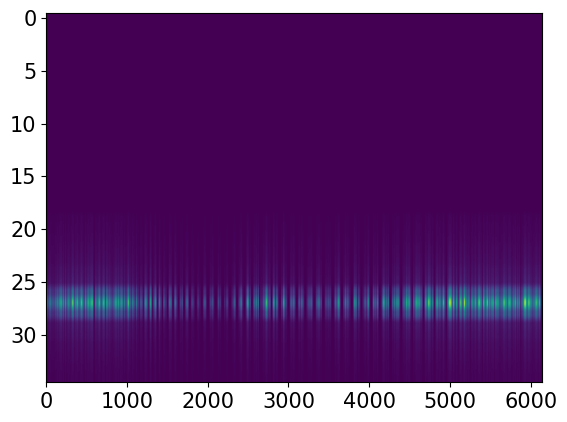

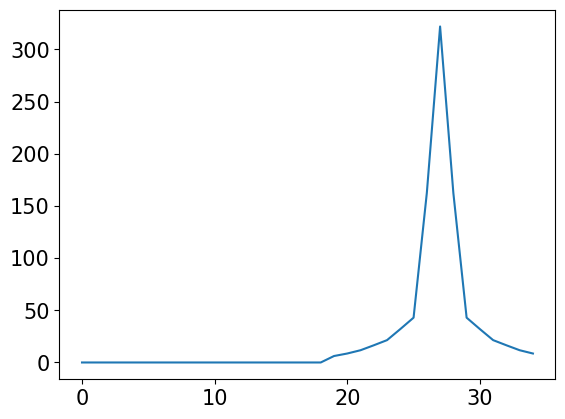

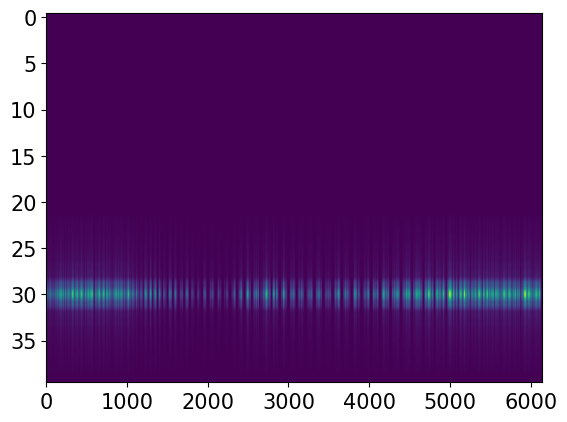

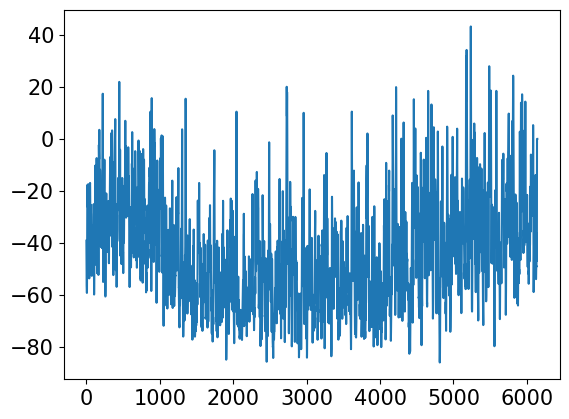

In [18]:
font = {'size': 15}

plt.rcParams.update({'font.size': font['size']})

plt.imshow(ABBA_series[1][-2], aspect='auto')
plt.show()

plt.plot(ABBA_series[1][-2][0:35,1000])
plt.show()

plt.imshow(position_B[1][-2][1024+84-20:1024+84+20,:],  aspect='auto')
plt.show()

plt.plot(position_B[1][-2][1024+84+5, :]*2-ABBA_series[-3][-2][17+5,:])
plt.show()

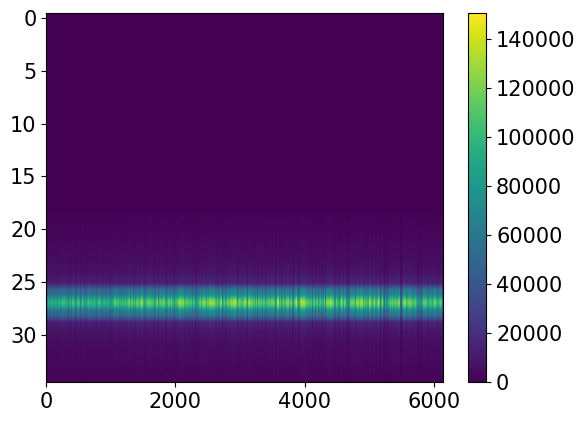

In [19]:
font = {'size': 15}

plt.rcParams.update({'font.size': font['size']})


plt.imshow(ABBA_stack[-3], aspect='auto')
plt.colorbar(plt.imshow(ABBA_stack[-3], aspect='auto'))

In [15]:
#Extract intrinsic PSF
day='0410'
key='K2166'

noise_free_data=np.load(path+'/%s/planet/%s/%s/noise_free/ABBA_stack.npy'%(day,name_model,key))

for i in range(noise_free_data.shape[0]):

    for j in range(3):

        detector=noise_free_data[i,:,j*2048:(j+1)*2048]

        PSF=np.nanmedian(detector, axis=1)

        PSF_norm = PSF/np.trapz(PSF)

        np.save(path+'/%s/planet/%s/%s/noise_free/PSF_%s_%s.npy'%(day,name_model,key, 29-i, j+1), PSF_norm)